# 6. Multiclass Classification Modeling - Urban

<a id='sections'></a>
**Sections**

- [**Multiclass Classification Modeling - Urban**](#multiclass-classification-modeling-urban)
    - [6.1. Data Preprocessing](#data-preprocessing)
        - (1) Import Data Files
        - (2) Convert Feature Types
        - (3) Mask Multi-Class Label
    - [6.2. Customize Score](#customize-score)
        - (1) Class-Weighted-f2score
        - (2) Weighted-Confusion_matrix-Score
        - (3) Check the Default Model
    - [6.3. Model Tuning](#model-tuning)
    - [6.4. Oversamling](#oversamling)
    - [6.5. Examine the Selected Model](#examine-the-selected-model)
        - (1) Model Performance
        - (2) Feature Importance
        - (3) Save the Model
        - (4) Visualize by Map
    - [6.6. Binary + Multiclass Model](#binary-multiclass-model)
        - (1) Examine the Performance on Testing Data
        - (2) Apply the Model for Future Prediction

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import pickle
from numpy import argmax
import importlib
import collections
import time
import getpass
import datetime as datetime
from shapely import wkt
from matplotlib import pyplot as plt

import categorical_embedder as ce
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer,  LabelEncoder
from sklearn.linear_model import LinearRegression,  LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE,SMOTENC
from imblearn.combine import SMOTEENN
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, brier_score_loss, auc
from sklearn.metrics import f1_score, fbeta_score, confusion_matrix, make_scorer, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import  StratifiedKFold, KFold, cross_val_score, StratifiedShuffleSplit
from sklearn.model_selection import  RepeatedStratifiedKFold, GridSearchCV, cross_validate
from sklearn import metrics
from xgboost import XGBClassifier

Using TensorFlow backend.
C:\Users\xl43843\Anaconda3\envs\geopandas\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\xl43843\Anaconda3\envs\geopandas\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\xl43843\Anaconda3\envs\geopandas\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\xl43843\Anaconda3\en

In [2]:
# import modules
import sys; sys.path.insert(0, '..')
import src.multiclass_models
# importlib.reload (src.multiclass_models)
from src.multiclass_models import *

# 6.1. Data Processing

[[back to top](#sections)]
<a id='data-preprocessing'></a>

## (1) Import Data Files

In [3]:
base_gis_dir  = "G:/CUUATS/Safety Forecasting Tool/"
base_file_dir = "L:/Safety Forecasting Tool/"
base_tool_dir = "L:/Safety_Crash Data Analysis/"

In [4]:
with open(base_file_dir+'data/processed/df_urban_train_2014_2017.pkl', 'rb') as f:
    df_urban_train = pickle.load(f)
with open(base_file_dir+'data/processed/df_urban_train_label_2014_2017.pkl', 'rb') as f:
    df_urban_train_label = pickle.load(f)
with open(base_file_dir+'data/processed/df_urban_test_2018.pkl', 'rb') as f:
    df_urban_test = pickle.load(f)
with open(base_file_dir+'data/processed/df_urban_test_label_2018.pkl', 'rb') as f:
    df_urban_test_label = pickle.load(f)

In [5]:
print(df_urban_train.shape)
print(df_urban_train_label.shape)
print(df_urban_test.shape)
print(df_urban_test_label.shape)

(25560, 62)
(25560,)
(6390, 62)
(6390,)


## (2) Convert Feature Types

In [6]:
# convert PC into a ordinal numeric field
df_urban_train=func_PC_numeric(df_urban_train)
df_urban_test=func_PC_numeric(df_urban_test)

# Remove features that should not be fed into the model
remove_list=['segment_id','overlap','geometry','Year']
targetlist = [i for i in list(df_urban_train.columns) if i not in remove_list]
df_urban_train_sub = df_urban_train[targetlist]
df_urban_test_sub = df_urban_test[targetlist]


## (3) Mask Multi-class Label

<mark> Different multi-class scenarios have been studied in this study </mark> 
- Plan A:
Classify cases of 0 crash, 1 crash, 2 crashes, >=3 crashes
- Plan B:
Classify cases of 0 crash, 1 Or 2 crashes, >=3 crashes
- Plan C:
Classify cases of 0 crash, 1 crash, >= 2 crashes

In [7]:
print(collections.Counter(df_urban_train_label))
print(collections.Counter(df_urban_test_label))

# # Plan A
# df_urban_train_cat_label=df_urban_train_label.mask(df_urban_train_label >= 3, 3)
# df_urban_test_cat_label=df_urban_test_label.mask(df_urban_test_label >= 3, 3)

# # Plan B
# df_urban_train_cat_label=df_urban_train_label.mask(df_urban_train_label==2, 1)
# df_urban_train_cat_label=y_train_cat_label.mask(df_urban_train_cat_label >= 3, 2)
# df_urban_test_cat_label=df_urban_test_label.mask(df_urban_test_label==2, 1)
# df_urban_test_cat_label=y_test_cat_label.mask(df_urban_test_cat_label >= 3, 2)

# Plan C
df_urban_train_cat_label=df_urban_train_label.mask(df_urban_train_label >= 3, 2)
df_urban_test_cat_label=df_urban_test_label.mask(df_urban_test_label >= 3, 2)

print(collections.Counter(df_urban_train_cat_label))
print(collections.Counter(df_urban_test_cat_label))

Counter({0.0: 21469, 1.0: 2351, 2.0: 740, 3.0: 354, 4.0: 203, 5.0: 121, 6.0: 82, 7.0: 56, 9.0: 42, 8.0: 37, 11.0: 22, 10.0: 19, 13.0: 16, 12.0: 11, 16.0: 8, 15.0: 5, 19.0: 4, 22.0: 4, 17.0: 3, 14.0: 3, 18.0: 3, 21.0: 2, 28.0: 2, 26.0: 1, 20.0: 1, 23.0: 1})
Counter({0.0: 5331, 1.0: 603, 2.0: 184, 3.0: 109, 4.0: 49, 5.0: 33, 6.0: 19, 7.0: 14, 8.0: 13, 9.0: 9, 10.0: 9, 11.0: 7, 13.0: 2, 15.0: 2, 26.0: 1, 12.0: 1, 25.0: 1, 24.0: 1, 17.0: 1, 19.0: 1})
Counter({0.0: 21469, 1.0: 2351, 2.0: 1740})
Counter({0.0: 5331, 1.0: 603, 2.0: 456})


In [8]:
X_train = df_urban_train_sub
y_train = df_urban_train_cat_label
X_test = df_urban_test_sub
y_test = df_urban_test_cat_label

X_train_OHtransformed=func_OHtransform_var(X_train)
OHfname = func_OHtransformed_var(X_train)
X_test_OHtransformed=func_OHtransform_var(X_test)

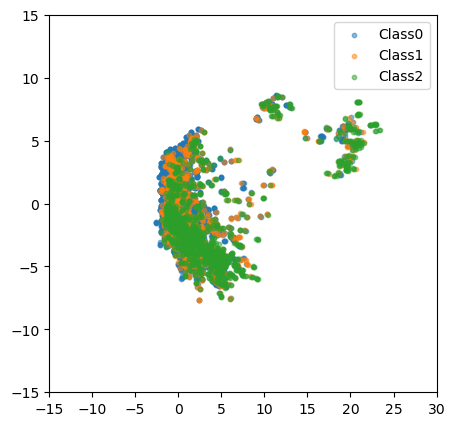

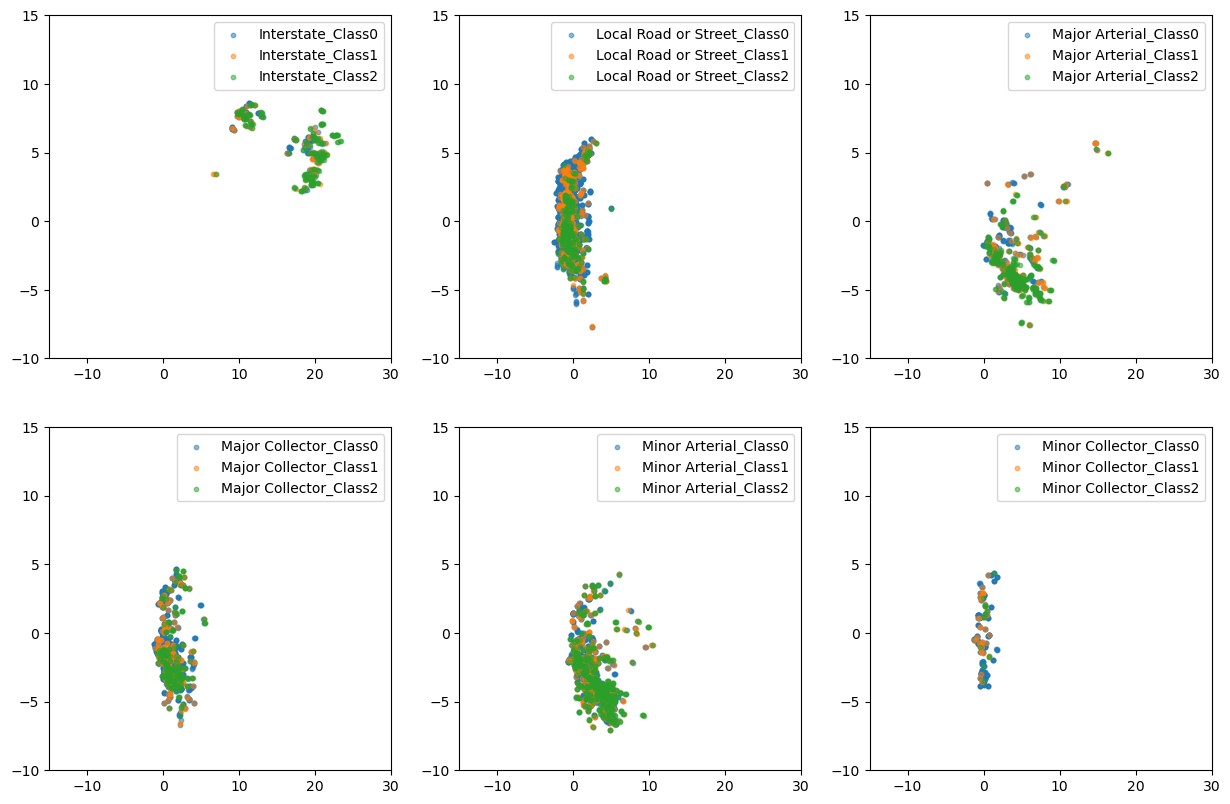

In [9]:
# Distribution of each roadway functional class in reduced dimension
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_OHtransformed_pca = pca.fit_transform(X_train_OHtransformed.toarray())
fig,ax=plt.subplots(figsize=(5,5),dpi=100)
for Class in [0,1,2]:
    df_X = X_train_OHtransformed_pca[df_urban_train_cat_label==Class]
    plt.scatter(df_X[:,0],df_X[:,1],label='Class'+str(Class),s=10,alpha=0.5)
plt.xlim((-15,30))
plt.ylim((-15,15))
plt.legend()

# Plot by roadway functional class
place_dict = dict({'Interstate':(0,0), 'Local Road or Street':(0,1), 'Major Arterial':(0,2),
                   'Major Collector':(1,0), 'Minor Arterial':(1,1), 'Minor Collector':(1,2)})
fig,ax=plt.subplots(2,3,figsize=(15,10),dpi=100)
for i,rdclass in enumerate(['Interstate', 'Local Road or Street', 'Major Arterial','Major Collector', 'Minor Arterial', 'Minor Collector']):
    df_X = X_train_OHtransformed_pca[df_urban_train_sub['functional_classification']==rdclass]
    df_y = df_urban_train_cat_label[df_urban_train_sub['functional_classification']==rdclass]
    ax[place_dict[rdclass]].scatter(df_X[df_y==0][:,0],df_X[df_y==0][:,1],label=rdclass+'_Class0',s=10,alpha=0.5)
    ax[place_dict[rdclass]].scatter(df_X[df_y==1][:,0],df_X[df_y==1][:,1],label=rdclass+'_Class1',s=10,alpha=0.5)
    ax[place_dict[rdclass]].scatter(df_X[df_y==2][:,0],df_X[df_y==2][:,1],label=rdclass+'_Class2',s=10,alpha=0.5)
    ax[place_dict[rdclass]].set_xlim((-15,30))
    ax[place_dict[rdclass]].set_ylim((-10,15))
    ax[place_dict[rdclass]].legend()

# 6.2. Customize Score

[[back to top](#sections)]
<a id='customize-score'></a>

<mark>**Goal setting**: </mark>
- <font color='purple'>The purpose of the multiclass model is to find out segments that have high crash risks (Class2), which have >=2 crashes. The model is designed to capture as many Class2 roads as possible.</font>
- <font color='purple'>The primary goal is to capture segments of high risks, the second goal is to identify segments that might have crashes (Class1), the last goal is to minimize the false alarm rate.</font>

To achieve the goal, two evaluation scores are designed:
- (1) class-weighted-f2score
- (2) weighted-confusion_matrix-score

## (1) Class-weighted-f2score

In [10]:
# # Plan A
# class_weight = {'No Crash':0.1,'1 Crash':0.2,'2 Crashes':0.3, '>=3 Crashes':0.4}
# # Plan B
# class_weight = {'No Crash':0.2,'1 OR 2 Crashes':0.3,'>=3 Crashes':0.5}
# Plan C
class_weight = {'No Crash':0.2,'1 Crash':0.3,'>=2 Crashes':0.5}
target_names = list(class_weight.keys())

## (2) Weighted-confusion_matrix-Score

When predicting(classifying) the roadway risk level in the real world, the costs of different misclassification cases are different and the benefits of correctly classifying different classes should be valued differently. For example, predicting(classifying) true Class2 as Class1 is much more dangerous than predicting true Class1 as Class0, predicting(classifying) true Class0 as Class2 is much more troublesome than predicting true Class0 as Class1, correctly identifying Class2 is more valuable than correctly identifying Class0 in the context of roadway risk assessment. To address this need, a **scoring matrix** is designed to evaluate correct classifications and misclassifications of different scenarios. 

In the scoring matrix, a negative value is assigned to each misclassification cell and a positive value is assigned to each correct classification cell. In other words, the "win(s)" of the model is measured by multiplying the correct classification cells with positive values in the scoring matrix, the "loss(es)" of the model is measured by multiplying the misclassification cells with negative values in the scoring matrix. The more dangerous/troublesome the misclassification case is, a smaller negative value (higher absolute value) is assigned. The more valuable the correct classification case is, a higher positive value is assigned. 

To evaluate all the models at the same scale, the **weighted_confusion_matrix_score**, which is between [-2,1], is developed. The weighted_confusion_matrix_score is calculated by dividing the total points earned by the model by the highest number of total points a model could earn (classifying all the classes correctly). 


**scoring matrix**:

|             | Predict Class0 | Predict Class1 | Predict Class2 |
| ----------- | ----------- | ----------- |----------- |
| True Class0 | +1           | -1          |-2       |
| True Class1 | -4          | +2           |-3       |
| True Class2 | -6          | -5          |+3       |

For example: 

In a dataset, Class0 has 124 samples, Class1 has 33 samples, Class2 has 14 samples.

The best performance the model could achieve is:

|             | Predict Class0 | Predict Class1 | Predict Class2 |
| ----------- | ----------- | ----------- |----------- |
| True Class0 | 124         | 0          |0    |
| True Class1 | 0           | 33         | 0     |
| True Class2 | 0           | 0          |14      |

The highest number of points a model could earn, which is the denominator, is: 124 * 1 + 33 * 2 + 14 * 3 = 232

The worst performance of a model could achieve is 124 * (-2) + 33 * (-4) + 14 * (-6) = -464

Thus, the worst weighted_confusion_matrix_score a model could have is -464/232=-2

Now, let's suppose a model get the following confusion_matrix:

|             | Predict Class0 | Predict Class1 | Predict Class2 |
| ----------- | ----------- | ----------- |----------- |
| True Class0 | 100         | 4          |20     |
| True Class1 | 1           | 20         |12      |
| True Class2 | 2           | 4         |8      |

The total points earned by the model is calculated as: 

100 * 1 + 4 * (-1) + 20 * (-2) + 1 * (-4) + 20 * 2 + 12 * (-3) + 2 * (-6) + 4 * (-5) + 8 * 3 = 48

=> The weighted confusion_matrix_score of this model is 48/232 = 0.207


In [11]:
scoring_matrix = np.array([[1,-1,-2],[-3,2,-4],[-6,-5,3]])

<mark>Model evaluation</mark>
- Step 1: Select the top 5 models with highest class-weighted f2score
- Step 2: Select the model with highest weighted confusion_matrix_score among the top 5 models.

## (3) Check the Default Model

In [12]:
sampling = None

XGBmodel = XGBClassifier(
    n_jobs=-1,random_state=42,
    objective='multi:softmax')

XGBmodel_pipeline = func_OH_classfication_pipeline (func_OHtransform_var, XGBmodel, sampling)
XGBmodel_pipeline_fitted = XGBmodel_pipeline.fit(X_train, y_train)
y_pred = XGBmodel_pipeline_fitted.predict(X_test)
print('\n')
print(metrics.confusion_matrix(y_test, y_pred))
multiclass_perf_fullreport(y_test, y_pred,class_weight)
wgt_cfm_score = np.sum(np.multiply(metrics.confusion_matrix(y_test, y_pred),scoring_matrix))/np.sum(np.multiply(y_test.value_counts().values,[1,2,3]))
print(wgt_cfm_score)

[Pipeline]  (step 1 of 3) Processing variable_transformer, total=   0.3s
[Pipeline] .......... (step 2 of 3) Processing sampling, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   6.7s


[[5191   70   70]
 [ 477   46   80]
 [ 181   50  225]]
0.3366223908918406


# 6.3. Model Tuning
[[back to top](#sections)]
<a id='model-tuning'></a>

In [13]:
with open(base_file_dir+'data/AWS Tuning results/Multiclass/Multiclass_Urban_XGB_search_results_round2.pkl', 'rb') as f:
    Multiclass_Urban_XGB_search_results = pickle.load(f)

In [14]:
cols_to_show = ['n_estimators','max_depth','eta','gamma','subsample','min_child_weight','wgt_f2score','wgt_cfm_score']
Multiclass_Urban_XGB_search_results[cols_to_show].sort_values(by=['wgt_f2score'],ascending=False).head(10)

n_estimators  max_depth  eta  gamma  subsample  min_child_weight  \
2950           250          8  0.3      7        0.8                 3   
5950           500          8  0.3      7        0.8                 3   
5860           500          7  0.3      7        0.8                 3   
5955           500          8  0.3      7        1.0                 3   
2350           200          8  0.3      7        0.8                 3   
4150           350          8  0.3      7        0.8                 3   
5355           450          8  0.3      7        1.0                 3   
4755           400          8  0.3      7        1.0                 3   
5953           500          8  0.3      7        0.8                 9   
5353           450          8  0.3      7        0.8                 9   

      wgt_f2score  wgt_cfm_score  
2950        0.503       0.302467  
5950        0.502       0.294497  
5860        0.502       0.305503  
5955        0.502       0.303352  
2350        0.501       0.302720  
4150        0.501       0.293485  
5355        0.500       0.301328  
4755        0.500       0.301455  
5953        0.500       0.303605  
5353        0.500       0.303352

In [15]:
Multiclass_Urban_XGB_search_results[cols_to_show].sort_values(by=['wgt_cfm_score'],ascending=False).head(10)

n_estimators  max_depth  eta  gamma  subsample  min_child_weight  \
5155           450          6  0.3      7        1.0                 3   
5260           450          7  0.3      7        0.8                 3   
5860           500          7  0.3      7        0.8                 3   
5157           450          6  0.3      7        1.0                 7   
5151           450          6  0.3      7        0.8                 5   
5755           500          6  0.3      7        1.0                 3   
1752           150          8  0.3      7        0.8                 7   
5750           500          6  0.3      7        0.8                 3   
3955           350          6  0.3      7        1.0                 3   
4060           350          7  0.3      7        0.8                 3   

      wgt_f2score  wgt_cfm_score  
5155        0.499       0.307906  
5260        0.500       0.305756  
5860        0.502       0.305503  
5157        0.495       0.305376  
5151        0.498       0.304617  
5755        0.497       0.304617  
1752        0.496       0.304617  
5750        0.499       0.304238  
3955        0.495       0.304111  
4060        0.498       0.303732

In [16]:
Best_wgt_f2score_models = Multiclass_Urban_XGB_search_results.sort_values(by=['wgt_f2score'],ascending=False).head(5)
Best_wgt_f2score_models.sort_values(by=['wgt_cfm_score'],ascending=False).head(5)

n_estimators  max_depth  eta  gamma  subsample  min_child_weight  \
5860           500          7  0.3      7        0.8                 3   
5955           500          8  0.3      7        1.0                 3   
2350           200          8  0.3      7        0.8                 3   
2950           250          8  0.3      7        0.8                 3   
5950           500          8  0.3      7        0.8                 3   

      wgt_precision  wgt_recall  wgt_f2score  NoCrash_precision  \
5860          0.561       0.493        0.502              0.896   
5955          0.549       0.494        0.502              0.898   
2350          0.549       0.494        0.501              0.898   
2950          0.546       0.496        0.503              0.898   
5950          0.535       0.496        0.502              0.898   

      NoCrash_recall  NoCrash_f2score  OneCrash_precision  OneCrash_recall  \
5860           0.956            0.944               0.267            0.134   
5955           0.951            0.940               0.260            0.146   
2350           0.952            0.940               0.264            0.144   
2950           0.949            0.938               0.261            0.148   
5950           0.941            0.933               0.241            0.153   

      OneCrash_f2score  TwoPlusCrash_precision  TwoPlusCrash_recall  \
5860             0.149                   0.603                0.522   
5955             0.160                   0.584                0.520   
2350             0.159                   0.581                0.520   
2950             0.162                   0.576                0.524   
5950             0.165                   0.566                0.524   

      TwoPlusCrash_f2score  wgt_cfm_score       time  
5860                 0.536       0.305503  11.098414  
5955                 0.531       0.303352  10.176696  
2350                 0.531       0.302720   5.190921  
2950                 0.534       0.302467   6.447611  
5950                 0.532       0.294497  12.753892

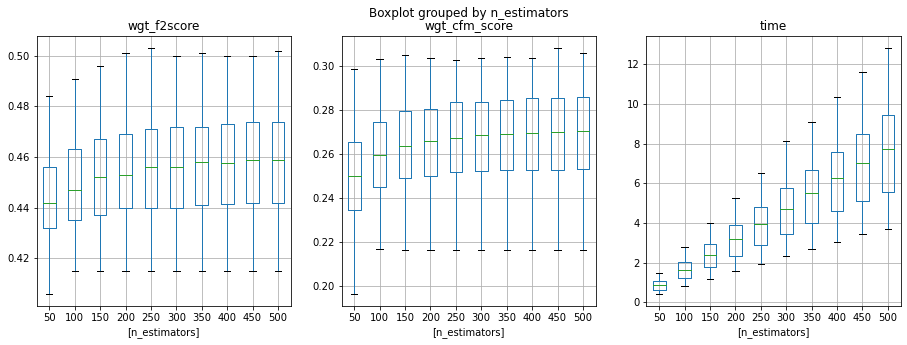

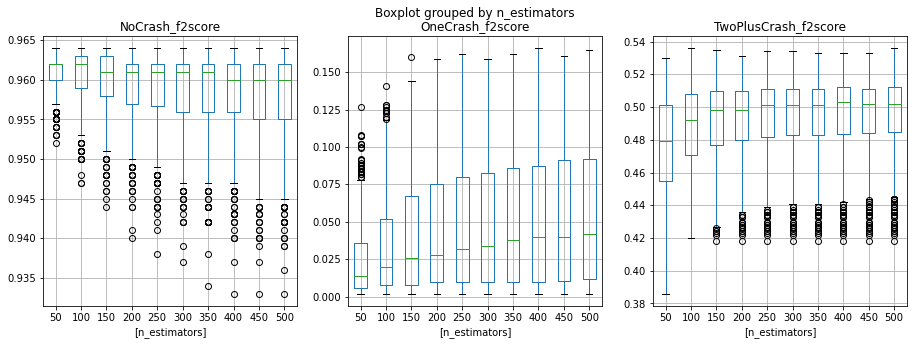

In [17]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
Multiclass_Urban_XGB_search_results.boxplot(column=['wgt_f2score'],by=['n_estimators'],ax=ax[0])
Multiclass_Urban_XGB_search_results.boxplot(column=['wgt_cfm_score'],by=['n_estimators'],ax=ax[1])
Multiclass_Urban_XGB_search_results.boxplot(column=['time'],by=['n_estimators'],ax=ax[2])
fig,ax = plt.subplots(1,3,figsize=(15,5))
Multiclass_Urban_XGB_search_results.boxplot(column=['NoCrash_f2score'],by=['n_estimators'],ax=ax[0])
Multiclass_Urban_XGB_search_results.boxplot(column=['OneCrash_f2score'],by=['n_estimators'],ax=ax[1])
Multiclass_Urban_XGB_search_results.boxplot(column=['TwoPlusCrash_f2score'],by=['n_estimators'],ax=ax[2])

<mark>Analysis</mark>
- From n_estimators=50 to n_estimators=250, the more estimators applied, the higher wgt_f2score median is and the higher wgt_cfm_score median is. This means that from n_estimators=50 to n_estimators=250, in general, a higher wgt_f2score and a higher wgt_cfm_score could be achieved if more n_estimators are applied.
- No matter how many n_estimators are applied, 'NoCrash' class has a very high f2score, 'OneCrash' class has an extremely low f2score, 'TwoPlusCrashes' class a moderate f2score.
- Applying more estimators would lead to a worse performance on NoCrash class (having a smaller minimum, a smaller 25 percentile and a smaller median of f2score) and a better performance on OnCrash class (having a  larger median and a larger 75 percentile of f2score).


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60]),
 <a list of 60 Text major ticklabel objects>)

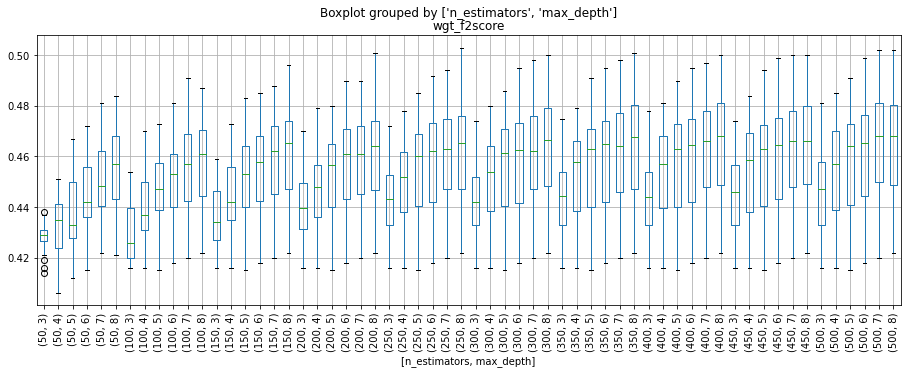

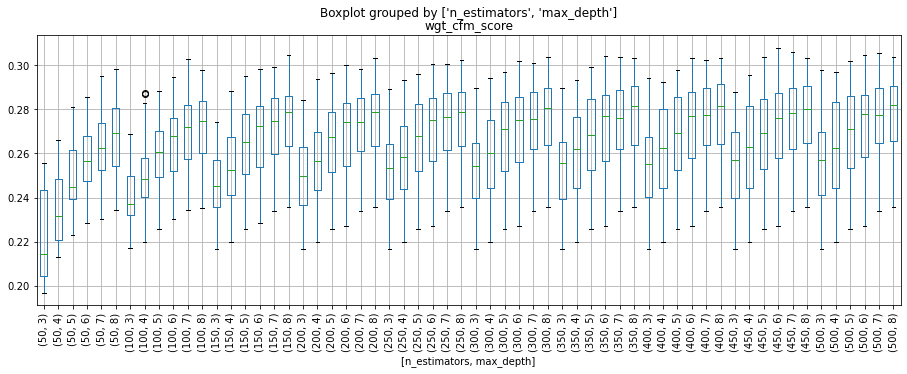

In [18]:
Multiclass_Urban_XGB_search_results.boxplot(column=['wgt_f2score'],by=['n_estimators','max_depth'],figsize=(15,5))
plt.xticks(rotation=90) 
Multiclass_Urban_XGB_search_results.boxplot(column=['wgt_cfm_score'],by=['n_estimators','max_depth'],figsize=(15,5))
plt.xticks(rotation=90) 

In [19]:
# Highest wgt_f2score
sampling=None
MulticlassXGBmodel = XGBClassifier(
    n_jobs=-1,random_state=42,
    objective='multi:softmax',
    n_estimators=250,max_depth=8,eta=0.3,subsample=0.8,
    min_child_weight=3)

MulticlassXGBmodel_fitted = MulticlassXGBmodel.fit(X_train_OHtransformed, y_train)
y_pred = MulticlassXGBmodel_fitted.predict(X_test_OHtransformed)
print(metrics.confusion_matrix(y_test, y_pred))
wgt_cfm_score = np.sum(np.multiply(metrics.confusion_matrix(y_test, y_pred),scoring_matrix))/np.sum(np.multiply(y_test.value_counts().values,[1,2,3]))
print(wgt_cfm_score)
multiclass_perf_fullreport(y_test, y_pred,class_weight)

[[5060  179   92]
 [ 430   89   84]
 [ 144   73  239]]
0.34623655913978496


precision  recall  f1-score  f2-score
No Crash          0.898   0.949     0.923     0.938
1 Crash           0.261   0.148     0.189     0.162
>=2 Crashes       0.576   0.524     0.549     0.534
micro avg         0.843   0.843     0.843     0.843
macro avg         0.578   0.540     0.553     0.545
weighted avg      0.546   0.496     0.516     0.503

In [20]:
# Highest wgt_cfm_score
sampling=None
MulticlassXGBmodel = XGBClassifier(
    n_jobs=-1,random_state=42,
    objective='multi:softmax',
    n_estimators=450,max_depth=6,eta=0.3,subsample=1,
    min_child_weight=3)

MulticlassXGBmodel_fitted = MulticlassXGBmodel.fit(X_train_OHtransformed, y_train)
y_pred = MulticlassXGBmodel_fitted.predict(X_test_OHtransformed)
print(metrics.confusion_matrix(y_test, y_pred))
wgt_cfm_score = np.sum(np.multiply(metrics.confusion_matrix(y_test, y_pred),scoring_matrix))/np.sum(np.multiply(y_test.value_counts().values,[1,2,3]))
print(wgt_cfm_score)
multiclass_perf_fullreport(y_test, y_pred,class_weight)

[[5121  129   81]
 [ 440   78   85]
 [ 153   66  237]]
0.3528146742567995


precision  recall  f1-score  f2-score
No Crash          0.896   0.961     0.927     0.947
1 Crash           0.286   0.129     0.178     0.145
>=2 Crashes       0.588   0.520     0.552     0.532
micro avg         0.851   0.851     0.851     0.851
macro avg         0.590   0.537     0.552     0.541
weighted avg      0.559   0.491     0.515     0.499

In [21]:
# Highest wgt_f2score and wgt_cfm_score
sampling=None
MulticlassXGBmodel = XGBClassifier(
    n_jobs=-1,random_state=42,
    objective='multi:softmax',
    n_estimators=500,max_depth=7,eta=0.1,subsample=0.8,
    min_child_weight=3)

MulticlassXGBmodel_fitted = MulticlassXGBmodel.fit(X_train_OHtransformed, y_train)
y_pred = MulticlassXGBmodel_fitted.predict(X_test_OHtransformed)
print(metrics.confusion_matrix(y_test, y_pred))
wgt_cfm_score = np.sum(np.multiply(metrics.confusion_matrix(y_test, y_pred),scoring_matrix))/np.sum(np.multiply(y_test.value_counts().values,[1,2,3]))
print(wgt_cfm_score)
multiclass_perf_fullreport(y_test, y_pred,class_weight)

[[5126  125   80]
 [ 448   76   79]
 [ 157   68  231]]
0.3471220746363061


precision  recall  f1-score  f2-score
No Crash          0.894   0.962     0.927     0.947
1 Crash           0.283   0.126     0.174     0.142
>=2 Crashes       0.592   0.507     0.546     0.522
micro avg         0.850   0.850     0.850     0.850
macro avg         0.590   0.531     0.549     0.537
weighted avg      0.560   0.483     0.511     0.493

# 6.4. Oversamling

[[back to top](#sections)]
<a id='oversamling'></a>

Oversampling Class 1 and Class 2

<mark>Conclusion: </mark>
- Model trained without oversampled data achieved better performance

# 6.5. Examine the Selected Model

[[back to top](#sections)]
<a id='examine-the-selected-model'></a>

## (1) Model Performance

In [22]:
# Highest wgt_f2score and wgt_cfm_score
sampling=None
MulticlassXGBmodel = XGBClassifier(
    n_jobs=-1,random_state=42,
    objective='multi:softmax',n_estimators=500,max_depth=7,eta=0.1,subsample=0.8,
    min_child_weight=3)

MulticlassXGBmodel_fitted = MulticlassXGBmodel.fit(X_train_OHtransformed, y_train)
y_pred = MulticlassXGBmodel_fitted.predict(X_test_OHtransformed)
print(metrics.confusion_matrix(y_test, y_pred))
wgt_cfm_score = np.sum(np.multiply(metrics.confusion_matrix(y_test, y_pred),scoring_matrix))/np.sum(np.multiply(y_test.value_counts().values,[1,2,3]))
print(wgt_cfm_score)
multiclass_perf_fullreport(y_test, y_pred,class_weight)

[[5126  125   80]
 [ 448   76   79]
 [ 157   68  231]]
0.3471220746363061


precision  recall  f1-score  f2-score
No Crash          0.894   0.962     0.927     0.947
1 Crash           0.283   0.126     0.174     0.142
>=2 Crashes       0.592   0.507     0.546     0.522
micro avg         0.850   0.850     0.850     0.850
macro avg         0.590   0.531     0.549     0.537
weighted avg      0.560   0.483     0.511     0.493

## (2) Feature Importance

Text(0.5, 1.0, 'Feature imprtance by weight \nthe number of times a feature is used to split the data across all trees')

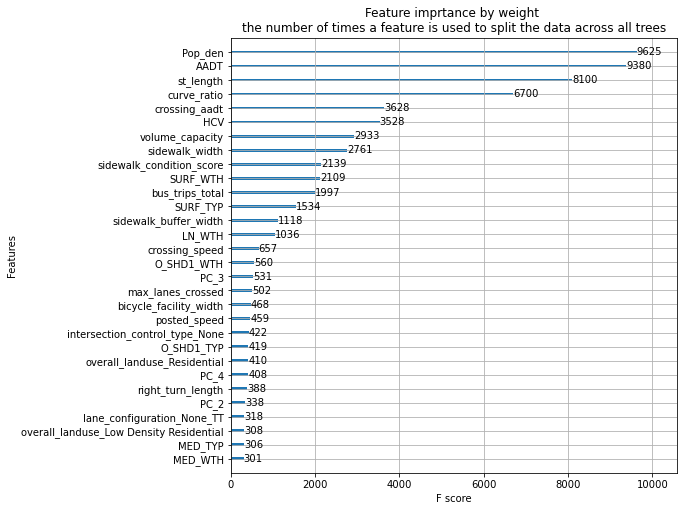

In [23]:
# feature importance
from xgboost import plot_importance

plt.rcParams["figure.figsize"] = (8, 8)

mapper = {'f{0}'.format(i): v for i, v in enumerate(OHfname)}
mapped = {mapper[k]: v for k, v in MulticlassXGBmodel_fitted.get_booster().get_score().items()}
#‘weight’: the number of times a feature is used to split the data across all trees.
plot_importance(mapped,max_num_features=30, importance_type='weight') # default
plt.title('Feature imprtance by weight \n'+'the number of times a feature is used to split the data across all trees')

## (3) Save the Model

In [24]:
# # Save model in pkl
# model_str = 'XGB'
# timestr=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# model_name = model_str+str(timestr)
# segment_intersection='segment'
# model_geography='urban'
# model_type='multiclass'
# print(model_name)
# path=base_file_dir+'models/'+segment_intersection+'/'+model_geography+'/'+model_type+'/'
# os.makedirs(path, exist_ok=True)
# with open(path+model_name+'.pkl', 'wb') as f:
#     pickle.dump(MulticlassXGBmodel_fitted, f)    

<mark>**XGB20210521-133356** renamed as **urban_multiclass_XGB_trainedw2014_2017**</mark>

## (4) Visualize by Map

### (a) Training  Data

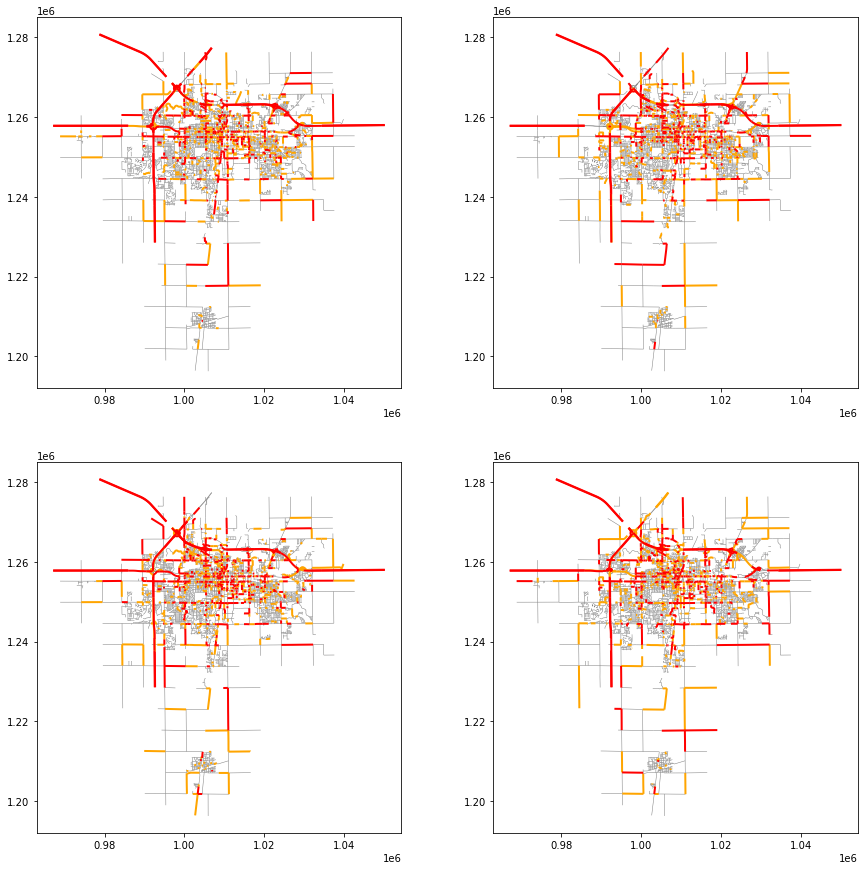

In [26]:
# Prepare plotting data
segment_intersection='segment'
model_geography='urban'

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15,15))
axes = axes.flatten()
plt_multiclass_observed_crashes_map (axes[0],df_urban_train, df_urban_train_cat_label, 2014)
plt_multiclass_observed_crashes_map (axes[1],df_urban_train, df_urban_train_cat_label, 2015)
plt_multiclass_observed_crashes_map (axes[2],df_urban_train, df_urban_train_cat_label, 2016)
plt_multiclass_observed_crashes_map (axes[3],df_urban_train, df_urban_train_cat_label, 2017)

plt.show()

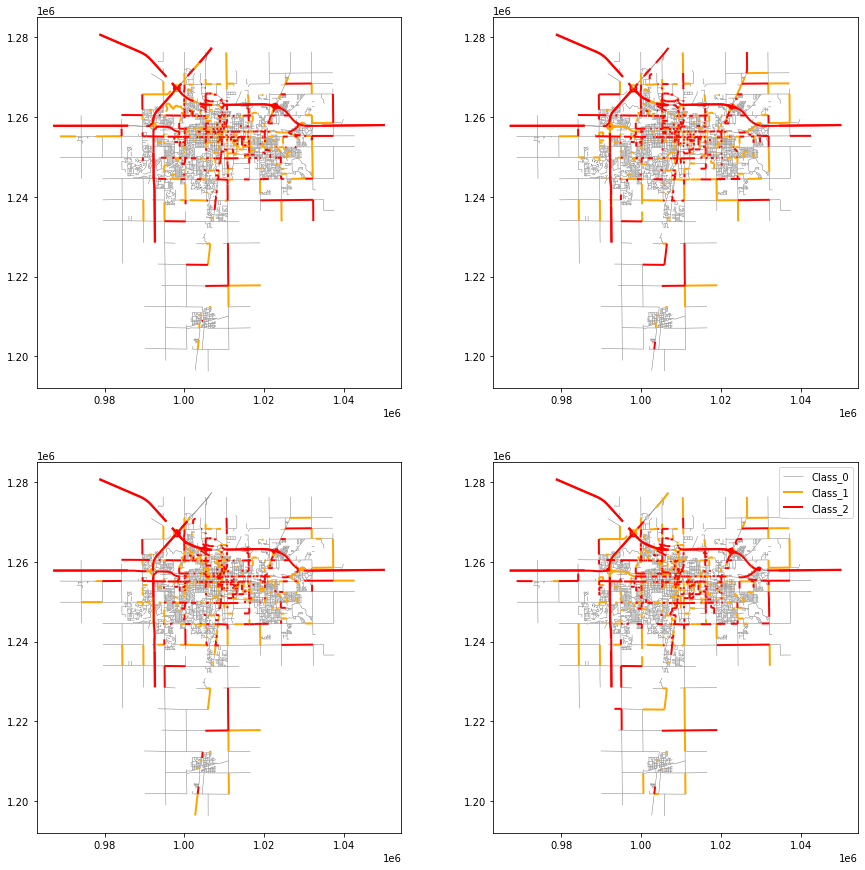

In [28]:
# Predicted values
y_pred = MulticlassXGBmodel_fitted.predict(X_train_OHtransformed)

segment_intersection='segment'
model_geography='urban'

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15,15))
axes = axes.flatten()

plt_multiclass_prediction_maps (axes[0],df_urban_train, y_pred, 2014)
plt_multiclass_prediction_maps (axes[1],df_urban_train, y_pred, 2015)
plt_multiclass_prediction_maps (axes[2],df_urban_train, y_pred, 2016)
plt_multiclass_prediction_maps (axes[3],df_urban_train, y_pred, 2017)

plt.show()

### (b) Testing Data

#### Observed Map

Text(0.5, 1.0, 'urban_XGB-MultiClass_observed')

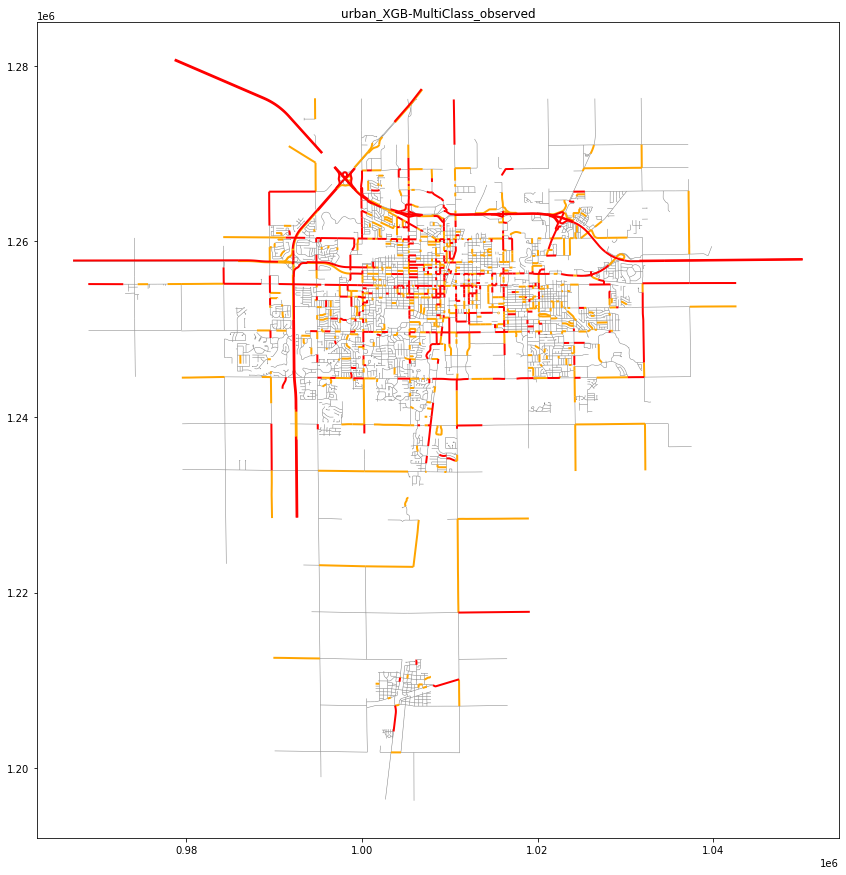

In [30]:
segment_intersection='segment'
model_geography='urban'
model_name = 'XGB-MultiClass'
map_name = model_geography+'_'+model_name+'_observed'
fig, axes = plt.subplots(figsize=(15,15))
plt_multiclass_observed_crashes_map (axes,df_urban_test,df_urban_test_cat_label,2018)
plt.title(map_name)

Text(0.5, 1.0, 'urban_XGB-MultiClass_prediction')

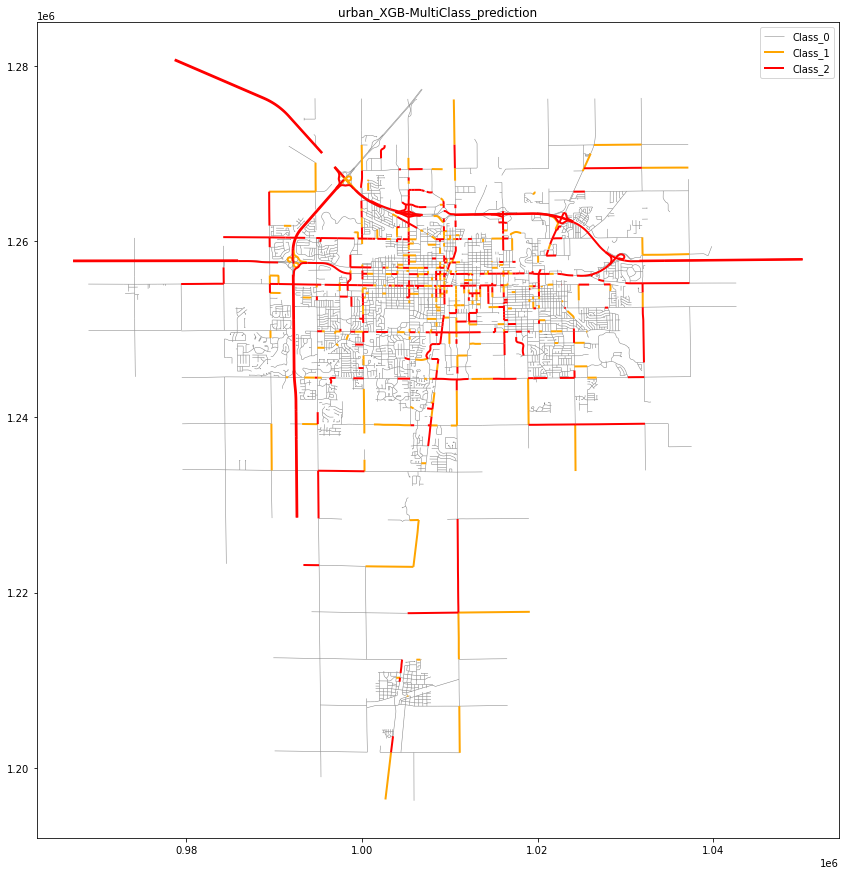

In [32]:
segment_intersection='segment'
model_geography='urban'
model_name = 'XGB-MultiClass'
map_name = model_geography+'_'+model_name+'_prediction'

# Predicted values
y_pred = MulticlassXGBmodel_fitted.predict(X_test_OHtransformed)

fig, axes = plt.subplots(figsize=(15,15))
plt_multiclass_prediction_maps (axes, df_urban_test, y_pred, 2018)
plt.title(map_name)

# 6.6. Binary + Multiclass Model

[[back to top](#sections)]
<a id='binary-multiclass-model'></a>

Reviewing the results of the binary model and the results of the multiclass model together can help 
- (i) decrease the chances of missing roadways that are of high risk 
- (ii) identify roadways that of high risk from the ones that are identified as "risky roads" by the binary model.

## (1) Examine the Performance on Testing Data

In [33]:
model_name = 'urban_binary_XGB_trainedw2014_2017_best_thres0.162.pkl'
with open(base_file_dir+'/models/segment/urban/binary/'+ model_name, 'rb') as f:
    urban_binary_xgb = pickle.load(f)
    
model_name = 'urban_multiclass_XGB_trainedw2014_2017.pkl'
with open(base_file_dir+'/models/segment/urban/multiclass/'+ model_name, 'rb') as f:
    urban_multiclass_xgb = pickle.load(f)    

In [34]:
# Binary model prediction results
best_thres = 0.162
y_test_pred_porba  = urban_binary_xgb.predict_proba(X_test_OHtransformed)[:,1]
Binary_y_pred = [1 if y>=best_thres else 0 for y in y_test_pred_porba]

# Multiclass model prediction results
Multiclass_y_pred = urban_multiclass_xgb.predict(X_test_OHtransformed) 

In [35]:
print('Multiclass model classification results of roadways that are classified as class_0 by binary model:')
Binarypred_0 = [list(np.array(Binary_y_pred)==0)][0]

df = pd.DataFrame((metrics.confusion_matrix(df_urban_test_cat_label.values[Binarypred_0], 
                                            Multiclass_y_pred[Binarypred_0])))
df = df.rename(index={0: "True Class 0", 1: "True Class 1", 2: "True Class 2"})
df = df.rename(columns={0:"MultiPred Class 0",1:"MultiPred Class 1",2:"MultiPred Class 2"})
print(df)
print('\n')
real_counts_df = pd.DataFrame()
real_counts_df["crash_counts"] = df_urban_test_label[Binarypred_0].values
real_counts_df["BinaryPred"] = 0
real_counts_df["MultiPred"] = Multiclass_y_pred[Binarypred_0]
real_counts_df = pd.DataFrame(real_counts_df.groupby(["crash_counts","BinaryPred","MultiPred"]).size())
real_counts_df = real_counts_df.rename(columns={0:"Counts"})
print('Multiclass model classification results of binary model Class_0 roadways & their true crash counts:')
real_counts_df

Multiclass model classification results of roadways that are classified as class_0 by binary model:
              MultiPred Class 0  MultiPred Class 1  MultiPred Class 2
True Class 0               4329                  6                  0
True Class 1                199                  1                  0
True Class 2                 34                  0                  2


Multiclass model classification results of binary model Class_0 roadways & their true crash counts:


Counts
crash_counts BinaryPred MultiPred        
0.0          0          0.0          4329
                        1.0             6
1.0          0          0.0           199
                        1.0             1
2.0          0          0.0            26
3.0          0          0.0             7
                        2.0             1
5.0          0          0.0             1
6.0          0          2.0             1

In [36]:
print('Multiclass model classification results of roadways that are classified as class_1 by binary model:')
Binarypred_1 = [list(np.array(Binary_y_pred)==1)][0]
df = pd.DataFrame((metrics.confusion_matrix(df_urban_test_cat_label.values[Binarypred_1], 
                                            Multiclass_y_pred[Binarypred_1])))
df = df.rename(index={0: "True Class 0", 1: "True Class 1", 2: "True Class 2"})
df = df.rename(columns={0:"MultiPred Class 0",1:"MultiPred Class 1",2:"MultiPred Class 2"})
print(df)
print('\n')
real_counts_df = pd.DataFrame()
real_counts_df["crash_counts"] = df_urban_test_label[Binarypred_1].values
real_counts_df["BinaryPred"] = 1
real_counts_df["MultiPred"] = Multiclass_y_pred[Binarypred_1]
real_counts_df = pd.DataFrame(real_counts_df.groupby(["crash_counts","BinaryPred","MultiPred"]).size())
real_counts_df = real_counts_df.rename(columns={0:"Counts"})
print('Multiclass model classification results of binary model Class_1 roadways & their true crash counts:')
real_counts_df

Multiclass model classification results of roadways that are classified as class_1 by binary model:
              MultiPred Class 0  MultiPred Class 1  MultiPred Class 2
True Class 0                797                119                 80
True Class 1                249                 75                 79
True Class 2                123                 68                229


Multiclass model classification results of binary model Class_1 roadways & their true crash counts:


Counts
crash_counts BinaryPred MultiPred        
0.0          1          0.0           797
                        1.0           119
                        2.0            80
1.0          1          0.0           249
                        1.0            75
                        2.0            79
2.0          1          0.0            70
                        1.0            30
                        2.0            58
3.0          1          0.0            27
                        1.0            19
                        2.0            55
4.0          1          0.0            13
                        1.0             7
                        2.0            29
5.0          1          0.0             5
                        1.0             3
                        2.0            24
6.0          1          0.0             1
                        1.0             4
                        2.0            13
7.0          1          0.0             2
                        1.0             1
                        2.0            11
8.0          1          0.0             2
                        1.0             2
                        2.0             9
9.0          1          0.0             2
                        1.0             1
                        2.0             6
10.0         1          0.0             1
                        1.0             1
                        2.0             7
11.0         1          2.0             7
12.0         1          2.0             1
13.0         1          2.0             2
15.0         1          2.0             2
17.0         1          2.0             1
19.0         1          2.0             1
24.0         1          2.0             1
25.0         1          2.0             1
26.0         1          2.0             1

<mark>Conclusion: </mark> 
- By applying the multi-class model, some of the roadways that have more than one crash counts but are identified as "Class 0" by the binary model are spotted. 
- By applying the multi-class model, a large number of roadways where no crash occurred but are identified as "Class 1" by the binary model are spotted. 
- Most of roadways that have >=2 crashes are successfully identified as "Class 2 (>=2 Crashes)" by the multi-class model.
- Roadways that have more than 11 crashes are all identified as "Class 1" by the binary model and identified as "Class 2 (>=2 Crashes)" by the multi-class model 
- Staff also examined the sequential approach of combining the binary and multiclass models under different scenarios as detailed in the rural notebook. 
- In order to harness the strength of both the binary and multiclass models, both models should be run independently and their prediction results be examined together to derive at the final risk assessment, as discussed in the following section.

## (2) Apply the Model for Future Prediction

The following risk level matrix can be applied when predicting roadway network risk level in the future. 

|             | Multiclass Class0 | Multiclass Class1 | Multiclass Class2 |
| ----------- | ----------- | ----------- |----------- |
| Binary Class0 |Low Risk     |Medium Risk  | Medium Risk |
| Binary Class1 |Medium Risk| Medium Risk |High Risk |
